In [229]:
import pandas as pd
import matplotlib.pyplot as plt
import pprint
import numpy as np
from matplotlib.font_manager import FontProperties
%matplotlib qt
fontP = FontProperties()
fontP.set_size('xx-small')

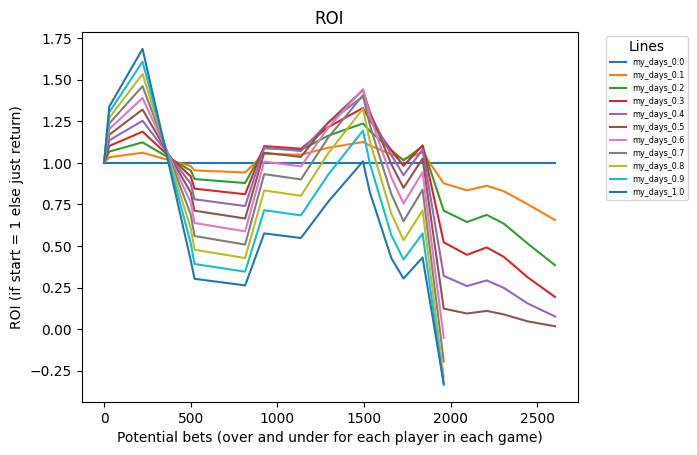

In [230]:
fig = plt.figure()
plt.title('ROI')
plt.xlabel('Potential bets (over and under for each player in each game)')
plt.ylabel('ROI (if start = 1 else just return)')
plots=[]

# Vars to change
start = 1 # 1 to see accual roi
pre = 0.1 # How much risk to take, reasonable values range from 0.25 to 0.01

for pre in np.arange(0,1.1,0.1):
    pre = pre.round(decimals=2)
    for csv in ["my"]:
        df = pd.read_csv(f"./{csv}.csv", sep=";")
        df['kelly_under'] = ((df['odds_under'] - 1) * df['pred_under_my'] - df['pred_over_my']) / (df['odds_under'] - 1)
        df['kelly_over'] = ((df['odds_over'] - 1) * df['pred_over_my'] - df['pred_under_my']) / (df['odds_over'] - 1) 

        days = {}

        for index, row in df.iterrows():
            if str(row['date']) not in days:
                days[str(row['date'])] = {
                        'bets': [{
                            "date": row['date'],
                            "answer": row['answer'],
                            "odds_over": row['odds_over'],
                            "odds_under": row['odds_under'],
                            "kelly_under": row['kelly_under'],
                            "kelly_over": row['kelly_over']
                        }]
                    }
            else:
                days[str(row['date'])]['bets'].append(
                        {
                            "date": row['date'],
                            "answer": row['answer'],
                            "odds_over": row['odds_over'],
                            "odds_under": row['odds_under'],
                            "kelly_under": row['kelly_under'],
                            "kelly_over": row['kelly_over']
                        }
                    )

        num_day = 0
        keys = list(days.keys())

        tot_bets=0
        plot_days=[0]
        plot_rois_day=[1]
        plot_rois_bet=[]

        # Loop trought days
        for day, info in days.items():
            if num_day == 0:
                info['start'] = start
            else:
                info['start'] = days[keys[num_day-1]]['end']
            if info['start'] > 0:
                info['end'] = info['start']

                # Loop through games in this day
                for bet in info['bets']:
                    for o_u in ["over", "under"]:
                        # Do i want to bet on this? (is kelly saying bet)
                        if bet[f"kelly_{o_u}"] > 0:
                            # Yes, how much should i bet?
                            how_much_to_bet = bet[f"kelly_{o_u}"] * pre * info['start']

                            # Remove from "kassa"
                            info['end'] -= how_much_to_bet

                            # Did i win? if so add how much i won
                            if (bet['answer'] == (o_u == "over")):
                                info['end'] += how_much_to_bet * bet[f"odds_{o_u}"]

                        tot_bets += 1
                        plot_rois_bet.append(info['end'])

                plot_rois_day.append(info['end'])
                plot_days.append(plot_days[-1] + len(info['bets']*2))

                num_day += 1



        #for days, info in days.items():
            #print(f"Ending {day} with {info['end']}% of starting capital")
        #print("")

        plots.append(plt.plot(plot_days, plot_rois_day, label = f"{csv}_days_{pre}")[0])
        #plots.append(plt.plot(list(range(0, tot_bets)), plot_rois_bet, label = f"{csv}_bets_{pre}")[0])

plt.legend(handles=plots, title='Lines', bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
plt.show()